In [3]:
import numpy as np
my_data1 = np.genfromtxt('ultimate.csv', delimiter=',')
my_data1.shape
# my_data2 = np.reshape(my_data1,(12,18,18))

(16706, 512)

In [4]:

# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output

In [5]:
# define the standalone discriminator model

def define_discriminator(in_shape=(None,512)):
    model = Sequential()
#   model.add(Conv2D(64, (4,4), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
#   model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
#   model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 1 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Reshape((18, 18, 128)))
    # upsample to 14x14
#   model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
#model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
#   model.add(Conv2D(1, (18,18), activation='sigmoid', padding='same'))
    return model
 
 # define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 
 # select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        print(examples.shape)
        pyplot.imshow(examples[i,0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=128):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    #save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=100): 
    count = []
    err01 = [] 
    err02 = []
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):     # Edit from (n_epochs) to (4,n_epochs)
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            #print('X_fake.shape = ',X_fake.shape)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            if j%10==0:
              print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
            #if j%30==0:
              #clear_output(wait=True)
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
        count = count + [i]
        err01 = err01 + [d_loss]
        err02 = err02 + [g_loss]
    return count, err01, err02


# size of the latent space
latent_dim = 100
# create the discriminator,
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data

dataset = my_data1
# train model
count, err01, err02 = train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 0s 6ms/step
>1, 1/167, d=1.977, g=0.745
2/2 [==============================] - 0s 7ms/step
>1, 11/167, d=1.177, g=0.652
2/2 [==============================] - 0s 8ms/step
>1, 21/167, d=1.360, g=0.607
2/2 [==============================] - 0s 7ms/step
>1, 31/167, d=0.772, g=0.618
2/2 [==============================] - 0s 7ms/step
>1, 41/167, d=0.625, g=0.589
2/2 [==============================] - 0s 5ms/step
>1, 51/167, d=0.505, g=0.586
2/2 [==============================] - 0s 9ms/step
>1, 61/167, d=0.598, g=0.476
2/2 [==============================] - 0s 6ms/step
>1, 71/167, d=0.687, g=0.517
2/2 [==============================] - 0s 7ms/step
>1, 81/167, d=0.778, g=0.499
2/2 [==============================] - 0s 7ms/step
>1, 91/167, d=0.705, g=0.491
2/2 [==============================] - 0s 6ms/step
>1, 101/167, d=0.656, g=0.438
2/2 [==============================] - 0s 5ms/step
>1, 111/167, d=0.698, g=0.438
2/2 [==============================] - 

>Accuracy real: 99%, fake: 100%
2/2 [==============================] - 0s 6ms/step
>11, 1/167, d=0.292, g=0.910
2/2 [==============================] - 0s 8ms/step
>11, 11/167, d=0.270, g=0.884
2/2 [==============================] - 0s 7ms/step
>11, 21/167, d=0.265, g=0.892
2/2 [==============================] - 0s 8ms/step
>11, 31/167, d=0.271, g=0.900
2/2 [==============================] - 0s 9ms/step
>11, 41/167, d=0.261, g=0.918
2/2 [==============================] - 0s 6ms/step
>11, 51/167, d=0.270, g=0.922
2/2 [==============================] - 0s 7ms/step
>11, 61/167, d=0.265, g=0.903
2/2 [==============================] - 0s 5ms/step
>11, 71/167, d=0.270, g=0.918
2/2 [==============================] - 0s 4ms/step
>11, 81/167, d=0.270, g=0.893
2/2 [==============================] - 0s 6ms/step
>11, 91/167, d=0.276, g=0.911
2/2 [==============================] - 0s 5ms/step
>11, 101/167, d=0.317, g=0.917
2/2 [==============================] - 0s 5ms/step
>11, 111/167, d=0.262, g=0

>Accuracy real: 100%, fake: 100%
2/2 [==============================] - 0s 8ms/step
>21, 1/167, d=0.272, g=0.913
2/2 [==============================] - 0s 9ms/step
>21, 11/167, d=0.264, g=0.905
2/2 [==============================] - 0s 9ms/step
>21, 21/167, d=0.274, g=0.912
2/2 [==============================] - 0s 5ms/step
>21, 31/167, d=0.259, g=0.907
2/2 [==============================] - 0s 10ms/step
>21, 41/167, d=0.270, g=0.913
2/2 [==============================] - 0s 7ms/step
>21, 51/167, d=0.270, g=0.917
2/2 [==============================] - 0s 5ms/step
>21, 61/167, d=0.258, g=0.934
2/2 [==============================] - 0s 7ms/step
>21, 71/167, d=0.265, g=0.912
2/2 [==============================] - 0s 6ms/step
>21, 81/167, d=0.264, g=0.910
2/2 [==============================] - 0s 5ms/step
>21, 91/167, d=0.262, g=0.919
2/2 [==============================] - 0s 10ms/step
>21, 101/167, d=0.266, g=0.916
2/2 [==============================] - 0s 11ms/step
>21, 111/167, d=0.256,

>Accuracy real: 99%, fake: 100%
2/2 [==============================] - 0s 7ms/step
>31, 1/167, d=0.233, g=1.038
2/2 [==============================] - 0s 6ms/step
>31, 11/167, d=0.230, g=1.015
2/2 [==============================] - 0s 7ms/step
>31, 21/167, d=0.236, g=1.026
2/2 [==============================] - 0s 7ms/step
>31, 31/167, d=0.232, g=1.033
2/2 [==============================] - 0s 8ms/step
>31, 41/167, d=0.233, g=1.041
2/2 [==============================] - 0s 8ms/step
>31, 51/167, d=0.229, g=1.041
2/2 [==============================] - 0s 6ms/step
>31, 61/167, d=0.229, g=1.039
2/2 [==============================] - 0s 7ms/step
>31, 71/167, d=0.229, g=1.043
2/2 [==============================] - 0s 12ms/step
>31, 81/167, d=0.240, g=1.040
2/2 [==============================] - 0s 5ms/step
>31, 91/167, d=0.229, g=1.026
2/2 [==============================] - 0s 12ms/step
>31, 101/167, d=0.227, g=1.052
2/2 [==============================] - 0s 6ms/step
>31, 111/167, d=0.230, g

>Accuracy real: 100%, fake: 100%
2/2 [==============================] - 0s 7ms/step
>41, 1/167, d=0.206, g=1.150
2/2 [==============================] - 0s 6ms/step
>41, 11/167, d=0.204, g=1.173
2/2 [==============================] - 0s 5ms/step
>41, 21/167, d=0.207, g=1.157
2/2 [==============================] - 0s 5ms/step
>41, 31/167, d=0.209, g=1.160
2/2 [==============================] - 0s 19ms/step
>41, 41/167, d=0.206, g=1.162
2/2 [==============================] - 0s 7ms/step
>41, 51/167, d=0.207, g=1.153
2/2 [==============================] - 0s 4ms/step
>41, 61/167, d=0.207, g=1.157
2/2 [==============================] - 0s 4ms/step
>41, 71/167, d=0.204, g=1.158
2/2 [==============================] - 0s 7ms/step
>41, 81/167, d=0.208, g=1.134
2/2 [==============================] - 0s 4ms/step
>41, 91/167, d=0.206, g=1.171
2/2 [==============================] - 0s 5ms/step
>41, 101/167, d=0.210, g=1.162
2/2 [==============================] - 0s 13ms/step
>41, 111/167, d=0.200, 

>Accuracy real: 100%, fake: 100%


In [6]:
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512)               51712     
                                                                 
 sequential (Sequential)     (None, 1)                 513       
                                                                 
Total params: 52,225
Trainable params: 51,712
Non-trainable params: 513
_________________________________________________________________


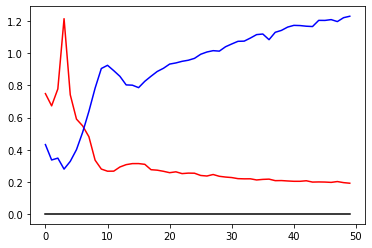

In [7]:
import matplotlib.pyplot as plt
plt.plot(count,err01,'-r') #dloss
plt.plot(count,err02,'-b') #gloss
plt.plot(count,0*np.array(count),'-k')

In [9]:
X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 10)


1/1 [==============================] - 0s 21ms/step


In [10]:
X_fake.shape

(10, 512)

In [11]:
for i in range(10):
  seq0 = X_fake[i]
  seq0 = (seq0 - np.min(seq0))/(np.max(seq0) - np.min(seq0))
  seq0 = 20*seq0
  for j in range(len(seq0)):
    seq0[j] = int(seq0[j])
  X_fake[i] = seq0


In [12]:
import pandas as pd
df = pd.DataFrame(X_fake)


In [13]:
ID_TO_AMINO_ACID = {0: '0',
                    1: 'A',
                    2: 'C',
                    3: 'D',
                    4: 'E',
                    5: 'F',
                    6: 'G',
                    7: 'H',
                    8: 'I',
                    9: 'K',
                    10: 'L',
                    11: 'M',
                    12: 'N',
                    13: 'P',
                    14: 'Q',
                    15: 'R',
                    16: 'S',
                    17: 'T',
                    18: 'V',
                    19: 'W',
                    20: 'Y'}

In [14]:
seq = ''
ds = []
for i in range(10):
  for j in range(512):
    seq = seq + ID_TO_AMINO_ACID[df.iloc[i][j]]
  ds = ds + [seq]
  seq = ''

In [15]:
pd.DataFrame(ds).to_csv('gen_seq.csv')